【問題1】機械翻訳の実行とコードリーディング

In [ ]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 3  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/MyDrive/fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text,sub_text = line.split('\t')
    # sub_textを自分で追加、使用はしない
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/3
125/125 [==============================] - 54s 407ms/step - loss: 0.9735 - val_loss: 1.0646
Epoch 2/3
125/125 [==============================] - 50s 402ms/step - loss: 0.9028 - val_loss: 1.0134
Epoch 3/3
125/125 [==============================] - 50s 399ms/step - loss: 0.8561 - val_loss: 0.9773
-
Input sentence: Go.
Decoded sentence: Aaree                                                       
-
Input sentence: Go.
Decoded sentence: Aaree                                                       
-
Input sentence: Go.
Decoded sentence: Aaree                                                       
-
Input sentence: Hi.
Decoded sentence: Arree                                                       
-
Input sentence: Hi.
Decoded sentence: Arree                                                       
-
Input sentence: Run!
D

〜コードリーディング〜

１から５行目 : ライブラリのimport  
６から１２行目：パラメータなどの定義  
１４から３３：input(英語)とtarget(フランス後)のtextとcharacterを準備している  
３５から４６：上のところで準備したものを整理とその情報を学習時にprintで出力するようにしている  
４８から６１：結果を入れるための辞書や空配列を準備  
６２から７２：decoder_input_data、decoder_target_dataを作成  
９６から：コンパイルし学習を行う  
１１３から：モデル定義  
１３５から：decode_sequence関数の定義  
１７３から：input_texts、decoded_sentenceを任意のループによりprintし出力



【問題2】イメージキャプショニングの学習済みモデルの実行

model.py　実行

一応のため、バージョンを下のように指定しておく

In [19]:
!pip install keras==2.2.0

!pip install tensorflow==1.15

!pip install Keras-Applications==1.0.7

!pip install h5py==2.10.0

     |████████████████████████████████| 300 kB 5.0 MB/s 
     |████████████████████████████████| 43 kB 906 kB/s 
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.2.0 which is incompatible.
tensorflow 2.6.0 requires keras-preprocessing~=1.1.2, but you have keras-preprocessing 1.0.1 which is incompatible.
     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.8 

In [1]:
cd drive/My Drive/

/content/drive/My Drive


In [2]:
!git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [2]:
cd coco/PythonAPI/

/content/drive/My Drive/coco/PythonAPI


In [4]:
!make
!python setup.py build
!python setup.py install

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-LSlbJj/python3.7-3.7.11=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-LSlbJj/python3.7-3.7.11=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy

In [3]:
cd ../../

/content/drive/My Drive


In [6]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [4]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [21]:
!pip install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [8]:
!python sample.py --image=png/example.png

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a group of giraffes standing next to each other . <end>


「a group of giraffes standing next to each other」と表示された。  
下がexample.png表示したものである。

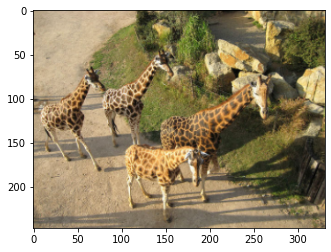

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
#画像の読み込み
im = Image.open("/content/example.png")
#画像をarrayに変換
im_list = np.asarray(im)
#貼り付け
plt.imshow(im_list)
#表示
plt.show()

【問題3】Kerasで動かしたい場合はどうするかを調査

kerasによる実行の場合は、RNNの一種であるLSTM（Long short-term memory）をRNN部分に用いてキャプション生成を行う方法がある。  
学習済みの重みを使用する場合、例とするとCNN部分に学習済みの重み（InceptionV3）を使って事前に各画像の特徴ベクトルを作成するという方法ができる。(今回のケースで使用できるかはわからないが・・・)  
調査をして１つ見つけた、イメージキャプショニングをKerasによる記述した参考例があったので合わせて参考に掲載する。  
調査をしていると、まだしっかりと理解はできていないがInceptionV3 を初期化して事前訓練された Imagenet 重みをロードするという形で重みを使用するような方法が多く説明されていた。  




調査をしていてネット上で見つけたkerasでのイメージキャプショニング実行例

In [ ]:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.merge import concatenate

def define_model(vocab_size, max_length):
    #photo feature extractor
    inputs1 = Input(shape=(2048, ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    #sequence model
    inputs2 = Input(shape=(max_length, ))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    #decoder model
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
        
    return model